In [1]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
from statsmodels.tsa.stattools import adfuller

First, we need to choose the signal we want to process and make it stationary using the differences between consecutive observations.

In [2]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)

8761
ADF Statistic: -26.464082
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


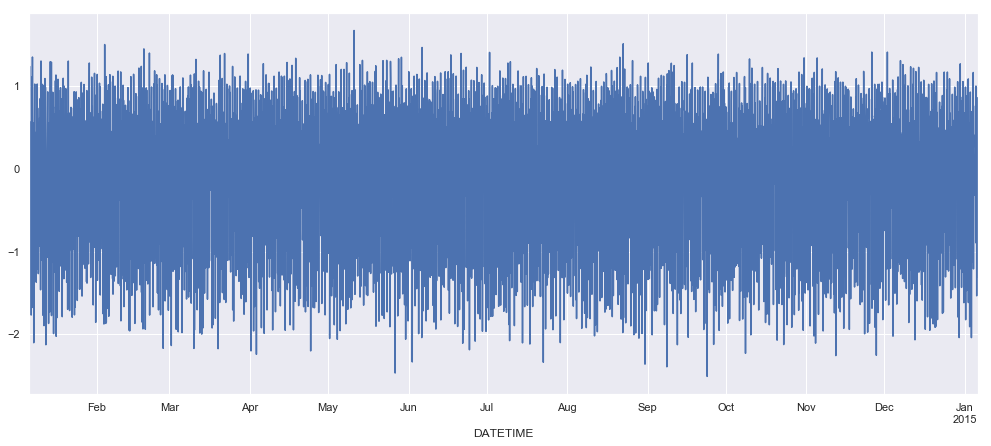

In [13]:
data_train1 = pd.read_csv('..//data//trn_set_1.csv', parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
series = pd.Series(data_train1['L_T7'])
X = series.values
print(len(X))
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
                         
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
                         
# save
stationary.to_csv('..//data//stationary.csv')
stationary.plot(figsize=(17,7))

Now we use the previously made stationary signal to plot the ACF and Pacf

In [6]:
series = Series.from_csv('..//data//stationary.csv')
#series_5days = series[0:120] #5 days

C:\Users\gabri\Anaconda3\lib\site-packages\pandas\core\series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [7]:
#plt.figure()
#plt.subplot(211)
#plot_acf(series_5days, ax=plt.gca())
#plt.subplot(212)
#plot_pacf(series_5days, ax=plt.gca())
#plt.show()

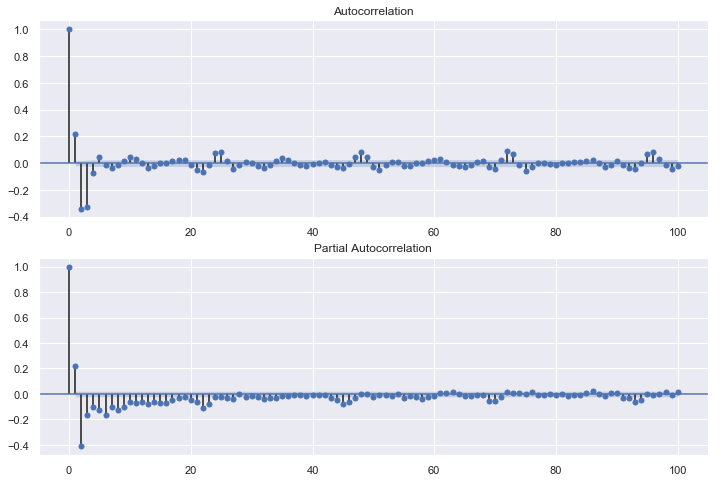

In [10]:
import statsmodels.api as sm
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=100, ax=ax2)


# ARMA with Grid Search

Imports

In [41]:
import warnings
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

Let's stop warnings from appearing.

In [42]:
import warnings
warnings.filterwarnings("ignore")

Now we can define a function for evaluating the different parameters for the ARMA model

In [43]:
#resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_arima_model_mse(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    error = np.mean(aics)
    return error

In [44]:
def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit(disp=0)
    return model_fit.aic


Now we define a method that loops over different sets of parameters for ARMA and evaluates the performance based on MSE.

In [45]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #error = evaluate_arima_model_mse(dataset, order)
                    error = evaluate_arima_model_aic(dataset, order)
                    if error < best_score:
                        best_score, best_cfg = error, order
                    #print('ARIMA%s MSE=%.3f' % (order,error))
                    print('ARIMA%s AIC=%.3f' % (order,error))
                except:
                    continue
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

In [46]:
#let's read the proper data again and choose the signals on which we want to fit ARMA
series = Series.from_csv('.//data//stationary.csv')
series

2014-01-06 01:00:00    0.289722
2014-01-06 02:00:00    0.394083
2014-01-06 03:00:00    0.957447
2014-01-06 04:00:00    1.236141
2014-01-06 05:00:00   -0.450809
2014-01-06 06:00:00   -1.011443
2014-01-06 07:00:00   -0.023721
2014-01-06 08:00:00    0.274854
2014-01-06 09:00:00    0.400082
2014-01-06 10:00:00   -0.182871
2014-01-06 11:00:00   -0.265715
2014-01-06 12:00:00    0.228275
2014-01-06 13:00:00    0.377107
2014-01-06 14:00:00   -0.361731
2014-01-06 15:00:00   -0.116906
2014-01-06 16:00:00    0.454717
2014-01-06 17:00:00    0.563457
2014-01-06 18:00:00    0.275036
2014-01-06 19:00:00   -1.766028
2014-01-06 20:00:00   -0.203478
2014-01-06 21:00:00   -0.035481
2014-01-06 22:00:00    0.002550
2014-01-06 23:00:00   -0.358259
2014-01-07 00:00:00    0.076927
2014-01-07 01:00:00    0.416657
2014-01-07 02:00:00    1.105028
2014-01-07 03:00:00    0.922211
2014-01-07 04:00:00   -1.008311
2014-01-07 05:00:00   -1.102145
2014-01-07 06:00:00    0.615048
                         ...   
2015-01-

In [47]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
#q_values = range(0, 3)
q_values = [0]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC=17959.759
ARIMA(0, 1, 0) AIC=21854.034
ARIMA(0, 2, 0) AIC=29059.657
ARIMA(1, 0, 0) AIC=17527.370
ARIMA(1, 1, 0) AIC=21686.228
ARIMA(1, 2, 0) AIC=27545.834
ARIMA(2, 0, 0) AIC=15898.099
ARIMA(2, 1, 0) AIC=20192.587
ARIMA(2, 2, 0) AIC=25843.620
ARIMA(4, 0, 0) AIC=15545.785
ARIMA(4, 1, 0) AIC=18548.150
ARIMA(4, 2, 0) AIC=22828.618
ARIMA(6, 0, 0) AIC=15167.665
ARIMA(6, 1, 0) AIC=17790.562
ARIMA(6, 2, 0) AIC=21394.490
ARIMA(8, 0, 0) AIC=14938.074
ARIMA(8, 1, 0) AIC=17233.663
ARIMA(8, 2, 0) AIC=20455.530
ARIMA(10, 0, 0) AIC=14814.809
ARIMA(10, 1, 0) AIC=16694.275
ARIMA(10, 2, 0) AIC=19588.545
Best ARIMA(10, 0, 0) AIC=14814.809
